In [98]:
import os
from typing import List
import numpy as np

class Point():
    def __init__(self, x: int, y: int, *, theta=None):
        self.x = int(x)
        self.y = int(y)
        self.theta = round(theta, 1) if theta else None
        
    def __repr__(self):
        if self.theta:
            return f"Point(x={self.x}, y={self.y}, theta={self.theta})"
        
        return f"Point(x={self.x}, y={self.y})"
    
    def __sub__(self, other):
        x = self.x - other.x
        y = self.y - other.y
        return Point(x, y)
    
    def __add__(self, other):
        x = self.x + other.x
        y = self.y + other.y
        return Point(x, y)
    
    def set_theta(self, front: Point, back: Point):
        self.theta= round(np.rad2deg( np.arctan2(front.y - back.y, front.x - back.x)) - 90.0, 1)

    @classmethod
    def from_encoder(cls, x: float, y: float, theta:float):
        
        x_mm = int(float(x) * 10)
        y_mm = int(float(y) * 10)
        theta = round(float(theta.strip()), 1)
        
        return Point(x_mm, y_mm, theta=theta)
        
        
        
        
start = Point(-56, -67)
front_marker = Point(0, 69)
back_marker = Point(0, -168)


dir_data = "/".join(os.path.abspath('').split("/")[:-2]) + "/data/Assignment_1_2/"
assert os.path.isdir(dir_data), "Could not find the data directory"

path_encoded_forward = dir_data + "forward_logs"
path_encoded_left = dir_data + "left_logs"
path_encoded_right = dir_data + "right_logs"

path_measurements_forward = dir_data + "measurements/pain_forward.csv"
path_measurements_left= dir_data + "measurements/pain_left.csv"
path_measurements_right = dir_data + "measurements/pain_right.csv"

assert all(os.path.isdir(path) for path in [path_encoded_forward, path_encoded_left, path_encoded_right])
assert all(os.path.isfile(path) for path in [path_measurements_forward, path_measurements_left, path_measurements_right])





In [110]:
def measured_to_pose(measurements: List[List[int]]) -> List[Point]:
    poses = []
    for measurement in measurements:
        if not measurement:
            continue
            
        front = Point(measurement[0], measurement[1])
        back = Point(measurement[2], measurement[3])
        
        front = front + start
        back = back + start
        
        real_x = (front.x - front_marker.x + back.x - back_marker.x ) / 2
        real_y = (front.y - front_marker.y + back.y - back_marker.y ) / 2
        
        pose = Point(real_x, real_y)
        pose.set_theta(front, back)
        
        poses.append(pose)
        
    return poses
        
        

def load_measurement(path: str) -> List[List[int]]:
    with open(path, 'r') as f:
        reader = csv.reader(f)
        print(f"Read file: '{path}'")
        print("Headers: ", next(reader))
        
        return [row for row in reader]
    
def load_last_encoder_measurement(dir_path: str) -> List[Point]:
    end_poses = []
    
    files = [os.path.join(dir_path, file) for file in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, file))]
    header = None
    
    for path in files:  
        with open (path, "r") as f:
            reader = csv.reader(f)
            if not header:
                header = next(reader)

            all_data = list(reader) 
            end_poses.append(Point.from_encoder(* all_data[-1][:3]))
            
                
    print(f"Read {len(files)} files from '{dir_path}'")
    print(f"Headers: {header}")
            
    return end_poses


    
transformed_forward = measured_to_pose(load_measurement(path_measurements_forward))
transformed_left = measured_to_pose(load_measurement(path_measurements_left))
transformed_right = measured_to_pose(load_measurement(path_measurements_right))

encoded_forward = load_last_encoder_measurement(path_encoded_forward)
encoded_left = load_last_encoder_measurement(path_encoded_left)
encoded_right = load_last_encoder_measurement(path_encoded_right)



print("\nforward")
for p, e in zip(transformed_forward, encoded_forward):
    print(p, e)
    
print("\nleft")
for p, e in zip(transformed_left, encoded_left):
    print(p, e)    

print("\nright")
for p, e in zip(transformed_right, encoded_right):
    print(p, e)
    
    
    

Read file: '/home/sd/Documents/code/mas-ss-21/SEE/data/Assignment_1_2/measurements/pain_forward.csv'
Headers:  ['x_front', ' y_front', ' x_back', ' y_back']
Read file: '/home/sd/Documents/code/mas-ss-21/SEE/data/Assignment_1_2/measurements/pain_left.csv'
Headers:  ['x_front', ' y_front', ' x_back', ' y_back']
Read file: '/home/sd/Documents/code/mas-ss-21/SEE/data/Assignment_1_2/measurements/pain_right.csv'
Headers:  ['x_front', ' y_front', ' x_back', ' y_back']
Read 42 files from '/home/sd/Documents/code/mas-ss-21/SEE/data/Assignment_1_2/forward_logs'
Headers: ['robot_position_x', ' robot_position_y', ' robot_orientation']
Read 40 files from '/home/sd/Documents/code/mas-ss-21/SEE/data/Assignment_1_2/left_logs'
Headers: ['robot_position_x', ' robot_position_y', ' robot_orientation']
Read 42 files from '/home/sd/Documents/code/mas-ss-21/SEE/data/Assignment_1_2/right_logs'
Headers: ['robot_position_x', ' robot_position_y', ' robot_orientation']

forward
Point(x=6, y=454, theta=-1.4) Point

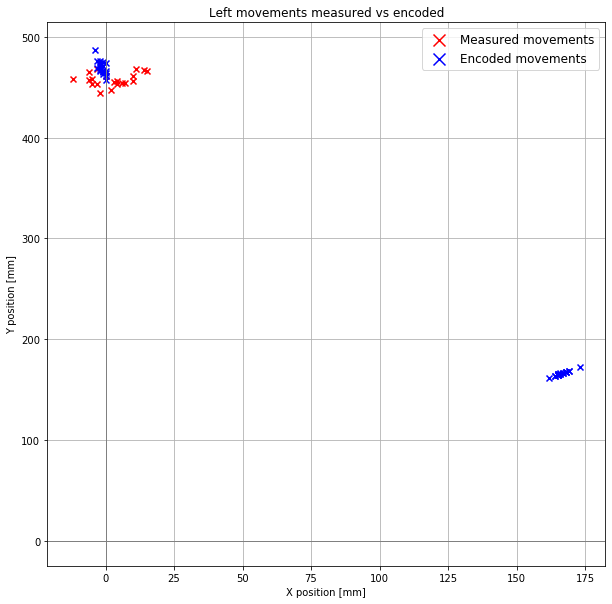

In [149]:
fig, ax_nstd = plt.subplots(figsize=(10, 10))
ax_nstd.axvline(c='grey', lw=1)
ax_nstd.axhline(c='grey', lw=1)

ax_nstd.scatter([p.x for p in transformed_forward], [p.y for p in transformed_forward], 
                color='r', label="Measured movements", marker='x')
ax_nstd.scatter([p.x for p in encoded_forward], [p.y for p in encoded_forward], 
                color='b', label="Encoded movements", marker='x', si)
ax_nstd.set_xlabel('X position [mm]')
ax_nstd.set_ylabel('Y position [mm]')
ax_nstd.set_title('Left movements measured vs encoded')
ax_nstd.legend(fontsize='large', markerscale=2.0)
ax_nstd.grid()
plt.show()

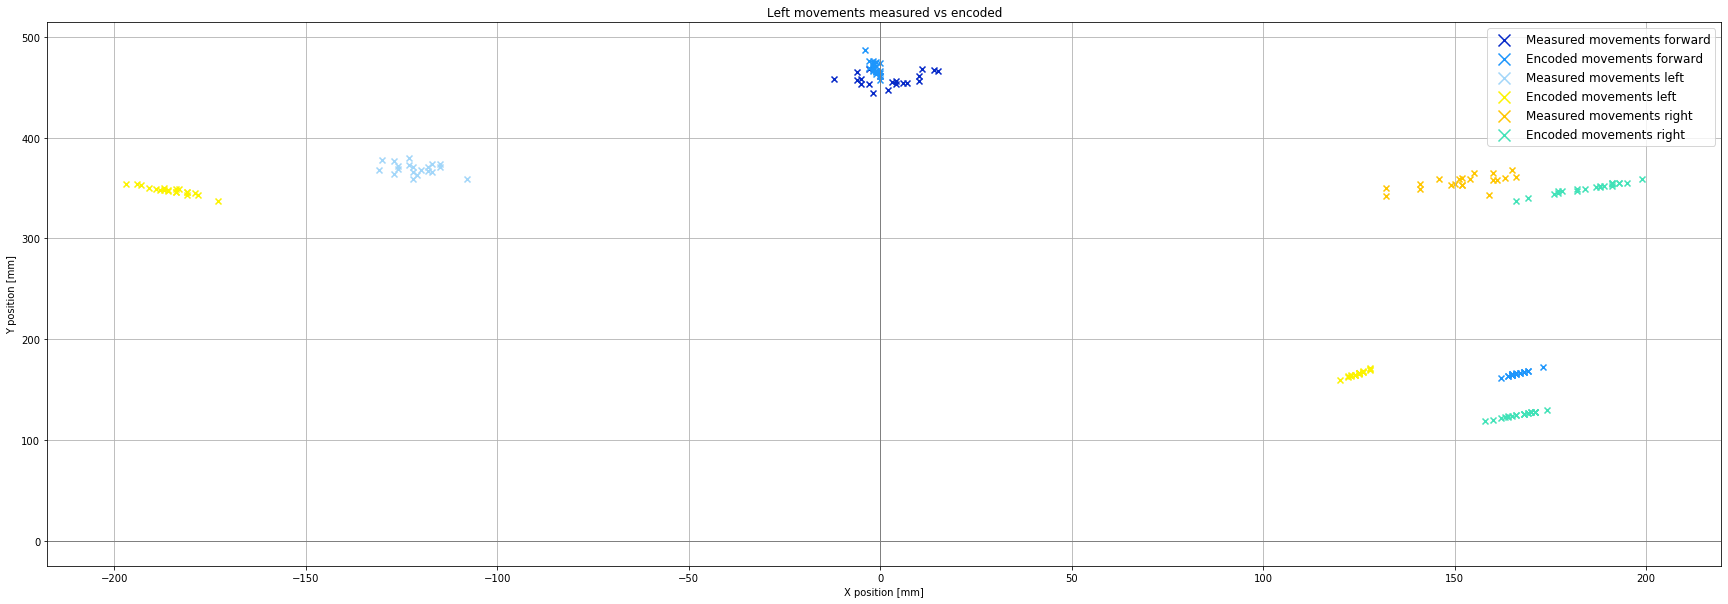

In [160]:
fig, ax_nstd = plt.subplots(figsize=(30, 10))
ax_nstd.axvline(c='grey', lw=1)
ax_nstd.axhline(c='grey', lw=1)
ax_nstd.scatter([p.x for p in transformed_forward], [p.y for p in transformed_forward], 
                color='#072AC8', label="Measured movements forward", marker='x')
ax_nstd.scatter([p.x for p in encoded_forward], [p.y for p in encoded_forward], 
                color='#1E96FC', label="Encoded movements forward", marker='x', )
ax_nstd.scatter([p.x for p in transformed_left], [p.y for p in transformed_left], 
                color='#A2D6F9', label="Measured movements left", marker='x')
ax_nstd.scatter([p.x for p in encoded_left], [p.y for p in encoded_left], 
                color='#FCF300', label="Encoded movements left", marker='x')
ax_nstd.scatter([p.x for p in transformed_right], [p.y for p in transformed_right], 
                color='#FFC600', label="Measured movements right", marker='x')
ax_nstd.scatter([p.x for p in encoded_right], [p.y for p in encoded_right], 
                color='#42E2B8', label="Encoded movements right", marker='x')

ax_nstd.set_xlabel('X position [mm]')
ax_nstd.set_ylabel('Y position [mm]')
ax_nstd.set_title('Left movements measured vs encoded')
ax_nstd.legend(fontsize='large', markerscale=2.0)
ax_nstd.grid()
plt.show()

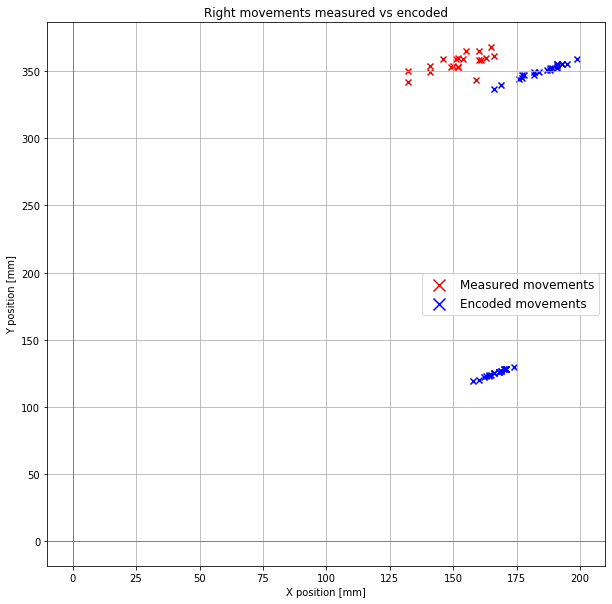

In [148]:
fig, ax_nstd = plt.subplots(figsize=(10, 10))
ax_nstd.axvline(c='grey', lw=1)
ax_nstd.axhline(c='grey', lw=1)

ax_nstd.scatter([p.x for p in transformed_right], [p.y for p in transformed_right], 
                color='r', label="Measured movements", marker='x')
ax_nstd.scatter([p.x for p in encoded_right], [p.y for p in encoded_right], 
                color='b', label="Encoded movements", marker='x')
ax_nstd.set_xlabel('X position [mm]')
ax_nstd.set_ylabel('Y position [mm]')
ax_nstd.set_title('Right movements measured vs encoded')
ax_nstd.legend(fontsize='large', markerscale=2.0)
ax_nstd.grid()
plt.show()